# Low-Light image enhancement comparison of the MIRNet and other networks on the LOL dataset.
## 22-여름 SW장기집중교육 3주차 프로젝트
### [2조] 박동옥, 김채연




# 사전 준비

## 구글 드라이브 마운트

In [ ]:
base_gdrive_path = 'drive/MyDrive/today_lecture'

## Imports

In [14]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
import numpy as np
from glob import glob
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

print(tf.__version__)

2.8.2


## 데이터셋

In [ ]:
!gdown https://drive.google.com/uc?id=1DdGIJ4PZPlF2ikl8mNM9V-PdVxVLbQi6
!unzip -q lol_dataset.zip

Downloading...
From: https://drive.google.com/uc?id=1DdGIJ4PZPlF2ikl8mNM9V-PdVxVLbQi6
To: /content/lol_dataset.zip
100% 347M/347M [00:01<00:00, 303MB/s]
replace lol_dataset/eval15/high/748.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace lol_dataset/eval15/high/665.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


## 유틸

In [ ]:
def save_model(model_name: str, model: keras.models.Model):
    model_json = model.to_json()
    with open(model_name, "w") as json_file:
        json_file.write(model_json)

from keras.models import model_from_json
from typing import Optional

# MIRNet

## Creating a TensorFlow Dataset

In [ ]:
random.seed(10)

IMAGE_SIZE = 128
BATCH_SIZE = 4
MAX_TRAIN_IMAGES = 300


def read_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image.set_shape([None, None, 3])
    image = tf.cast(image, dtype=tf.float32) / 255.0
    return image


def random_crop(low_image, enhanced_image):
    low_image_shape = tf.shape(low_image)[:2]
    low_w = tf.random.uniform(
        shape=(), maxval=low_image_shape[1] - IMAGE_SIZE + 1, dtype=tf.int32
    )
    low_h = tf.random.uniform(
        shape=(), maxval=low_image_shape[0] - IMAGE_SIZE + 1, dtype=tf.int32
    )
    enhanced_w = low_w
    enhanced_h = low_h
    low_image_cropped = low_image[
        low_h : low_h + IMAGE_SIZE, low_w : low_w + IMAGE_SIZE
    ]
    enhanced_image_cropped = enhanced_image[
        enhanced_h : enhanced_h + IMAGE_SIZE, enhanced_w : enhanced_w + IMAGE_SIZE
    ]
    return low_image_cropped, enhanced_image_cropped


def load_data(low_light_image_path, enhanced_image_path):
    low_light_image = read_image(low_light_image_path)
    enhanced_image = read_image(enhanced_image_path)
    low_light_image, enhanced_image = random_crop(low_light_image, enhanced_image)
    return low_light_image, enhanced_image


def get_dataset(low_light_images, enhanced_images):
    dataset = tf.data.Dataset.from_tensor_slices((low_light_images, enhanced_images))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset


train_low_light_images = sorted(glob("./lol_dataset/our485/low/*"))[:MAX_TRAIN_IMAGES]
train_enhanced_images = sorted(glob("./lol_dataset/our485/high/*"))[:MAX_TRAIN_IMAGES]

val_low_light_images = sorted(glob("./lol_dataset/our485/low/*"))[MAX_TRAIN_IMAGES:]
val_enhanced_images = sorted(glob("./lol_dataset/our485/high/*"))[MAX_TRAIN_IMAGES:]

test_low_light_images = sorted(glob("./lol_dataset/eval15/low/*"))
test_enhanced_images = sorted(glob("./lol_dataset/eval15/high/*"))


train_dataset = get_dataset(train_low_light_images, train_enhanced_images)
val_dataset = get_dataset(val_low_light_images, val_enhanced_images)


print("Train Dataset:", train_dataset)
print("Val Dataset:", val_dataset)


Train Dataset: <BatchDataset element_spec=(TensorSpec(shape=(4, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, None, None, 3), dtype=tf.float32, name=None))>
Val Dataset: <BatchDataset element_spec=(TensorSpec(shape=(4, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, None, None, 3), dtype=tf.float32, name=None))>


## MIRNet Model

### Selective Kernel Feature Fusion

In [ ]:
def selective_kernel_feature_fusion(
    multi_scale_feature_1, multi_scale_feature_2, multi_scale_feature_3
):
    channels = list(multi_scale_feature_1.shape)[-1]
    combined_feature = layers.Add()(
        [multi_scale_feature_1, multi_scale_feature_2, multi_scale_feature_3]
    )
    gap = layers.GlobalAveragePooling2D()(combined_feature)
    channel_wise_statistics = tf.reshape(gap, shape=(-1, 1, 1, channels))
    compact_feature_representation = layers.Conv2D(
        filters=channels // 8, kernel_size=(1, 1), activation="relu"
    )(channel_wise_statistics)
    feature_descriptor_1 = layers.Conv2D(
        channels, kernel_size=(1, 1), activation="softmax"
    )(compact_feature_representation)
    feature_descriptor_2 = layers.Conv2D(
        channels, kernel_size=(1, 1), activation="softmax"
    )(compact_feature_representation)
    feature_descriptor_3 = layers.Conv2D(
        channels, kernel_size=(1, 1), activation="softmax"
    )(compact_feature_representation)
    feature_1 = multi_scale_feature_1 * feature_descriptor_1
    feature_2 = multi_scale_feature_2 * feature_descriptor_2
    feature_3 = multi_scale_feature_3 * feature_descriptor_3
    aggregated_feature = layers.Add()([feature_1, feature_2, feature_3])
    return aggregated_feature


### Dual Attention Unit

In [ ]:
def spatial_attention_block(input_tensor):
    average_pooling = tf.reduce_max(input_tensor, axis=-1)
    average_pooling = tf.expand_dims(average_pooling, axis=-1)
    max_pooling = tf.reduce_mean(input_tensor, axis=-1)
    max_pooling = tf.expand_dims(max_pooling, axis=-1)
    concatenated = layers.Concatenate(axis=-1)([average_pooling, max_pooling])
    feature_map = layers.Conv2D(1, kernel_size=(1, 1))(concatenated)
    feature_map = tf.nn.sigmoid(feature_map)
    return input_tensor * feature_map


def channel_attention_block(input_tensor):
    channels = list(input_tensor.shape)[-1]
    average_pooling = layers.GlobalAveragePooling2D()(input_tensor)
    feature_descriptor = tf.reshape(average_pooling, shape=(-1, 1, 1, channels))
    feature_activations = layers.Conv2D(
        filters=channels // 8, kernel_size=(1, 1), activation="relu"
    )(feature_descriptor)
    feature_activations = layers.Conv2D(
        filters=channels, kernel_size=(1, 1), activation="sigmoid"
    )(feature_activations)
    return input_tensor * feature_activations


def dual_attention_unit_block(input_tensor):
    channels = list(input_tensor.shape)[-1]
    feature_map = layers.Conv2D(
        channels, kernel_size=(3, 3), padding="same", activation="relu"
    )(input_tensor)
    feature_map = layers.Conv2D(channels, kernel_size=(3, 3), padding="same")(
        feature_map
    )
    channel_attention = channel_attention_block(feature_map)
    spatial_attention = spatial_attention_block(feature_map)
    concatenation = layers.Concatenate(axis=-1)([channel_attention, spatial_attention])
    concatenation = layers.Conv2D(channels, kernel_size=(1, 1))(concatenation)
    return layers.Add()([input_tensor, concatenation])


### Multi-Scale Residual Block

In [ ]:
def down_sampling_module(input_tensor):
    channels = list(input_tensor.shape)[-1]
    main_branch = layers.Conv2D(channels, kernel_size=(1, 1), activation="relu")(
        input_tensor
    )
    main_branch = layers.Conv2D(
        channels, kernel_size=(3, 3), padding="same", activation="relu"
    )(main_branch)
    main_branch = layers.MaxPooling2D()(main_branch)
    main_branch = layers.Conv2D(channels * 2, kernel_size=(1, 1))(main_branch)
    skip_branch = layers.MaxPooling2D()(input_tensor)
    skip_branch = layers.Conv2D(channels * 2, kernel_size=(1, 1))(skip_branch)
    return layers.Add()([skip_branch, main_branch])


def up_sampling_module(input_tensor):
    channels = list(input_tensor.shape)[-1]
    main_branch = layers.Conv2D(channels, kernel_size=(1, 1), activation="relu")(
        input_tensor
    )
    main_branch = layers.Conv2D(
        channels, kernel_size=(3, 3), padding="same", activation="relu"
    )(main_branch)
    main_branch = layers.UpSampling2D()(main_branch)
    main_branch = layers.Conv2D(channels // 2, kernel_size=(1, 1))(main_branch)
    skip_branch = layers.UpSampling2D()(input_tensor)
    skip_branch = layers.Conv2D(channels // 2, kernel_size=(1, 1))(skip_branch)
    return layers.Add()([skip_branch, main_branch])


# MRB Block
def multi_scale_residual_block(input_tensor, channels):
    # features
    level1 = input_tensor
    level2 = down_sampling_module(input_tensor)
    level3 = down_sampling_module(level2)
    # DAU
    level1_dau = dual_attention_unit_block(level1)
    level2_dau = dual_attention_unit_block(level2)
    level3_dau = dual_attention_unit_block(level3)
    # SKFF
    level1_skff = selective_kernel_feature_fusion(
        level1_dau,
        up_sampling_module(level2_dau),
        up_sampling_module(up_sampling_module(level3_dau)),
    )
    level2_skff = selective_kernel_feature_fusion(
        down_sampling_module(level1_dau), level2_dau, up_sampling_module(level3_dau)
    )
    level3_skff = selective_kernel_feature_fusion(
        down_sampling_module(down_sampling_module(level1_dau)),
        down_sampling_module(level2_dau),
        level3_dau,
    )
    # DAU 2
    level1_dau_2 = dual_attention_unit_block(level1_skff)
    level2_dau_2 = up_sampling_module((dual_attention_unit_block(level2_skff)))
    level3_dau_2 = up_sampling_module(
        up_sampling_module(dual_attention_unit_block(level3_skff))
    )
    # SKFF 2
    skff_ = selective_kernel_feature_fusion(level1_dau_2, level3_dau_2, level3_dau_2)
    conv = layers.Conv2D(channels, kernel_size=(3, 3), padding="same")(skff_)
    return layers.Add()([input_tensor, conv])

### MIRNet Model

In [ ]:
def recursive_residual_group(input_tensor, num_mrb, channels):
    conv1 = layers.Conv2D(channels, kernel_size=(3, 3), padding="same")(input_tensor)
    for _ in range(num_mrb):
        conv1 = multi_scale_residual_block(conv1, channels)
    conv2 = layers.Conv2D(channels, kernel_size=(3, 3), padding="same")(conv1)
    return layers.Add()([conv2, input_tensor])


def mirnet_model(num_rrg, num_mrb, channels):
    input_tensor = keras.Input(shape=[None, None, 3])
    x1 = layers.Conv2D(channels, kernel_size=(3, 3), padding="same")(input_tensor)
    for _ in range(num_rrg):
        x1 = recursive_residual_group(x1, num_mrb, channels)
    conv = layers.Conv2D(3, kernel_size=(3, 3), padding="same")(x1)
    output_tensor = layers.Add()([input_tensor, conv])
    return keras.Model(input_tensor, output_tensor)


model = mirnet_model(num_rrg=3, num_mrb=2, channels=64)


### Training

Epoch 1/10
75/75 [==============================] - 133s 1s/step - loss: 0.2012 - peak_signal_noise_ratio: 62.3779 - val_loss: 0.1216 - val_peak_signal_noise_ratio: 65.8216 - lr: 1.0000e-04
Epoch 2/10
75/75 [==============================] - 83s 1s/step - loss: 0.1675 - peak_signal_noise_ratio: 63.6365 - val_loss: 0.1289 - val_peak_signal_noise_ratio: 65.6556 - lr: 1.0000e-04
Epoch 3/10
75/75 [==============================] - 85s 1s/step - loss: 0.1711 - peak_signal_noise_ratio: 63.3098 - val_loss: 0.1223 - val_peak_signal_noise_ratio: 65.8840 - lr: 1.0000e-04
Epoch 4/10
75/75 [==============================] - 92s 1s/step - loss: 0.1651 - peak_signal_noise_ratio: 63.6370 - val_loss: 0.1225 - val_peak_signal_noise_ratio: 65.8355 - lr: 1.0000e-04
Epoch 5/10
75/75 [==============================] - 85s 1s/step - loss: 0.1638 - peak_signal_noise_ratio: 63.8579 - val_loss: 0.1236 - val_peak_signal_noise_ratio: 65.9803 - lr: 1.0000e-04
Epoch 6/10
75/75 [==============================] - 86

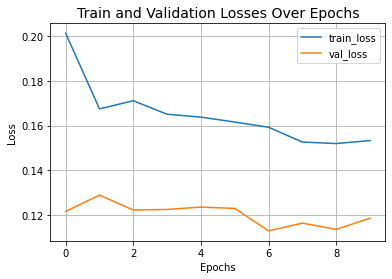

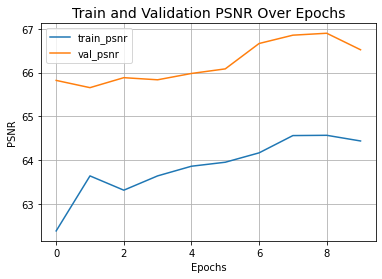

In [ ]:
def charbonnier_loss(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.square(y_true - y_pred) + tf.square(1e-3)))


def peak_signal_noise_ratio(y_true, y_pred):
    return tf.image.psnr(y_pred, y_true, max_val=255.0)


optimizer = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(
    optimizer=optimizer, loss=charbonnier_loss, metrics=[peak_signal_noise_ratio]
)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    #epochs=50,
    epochs=10,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_peak_signal_noise_ratio",
            factor=0.5,
            patience=5,
            verbose=1,
            min_delta=1e-7,
            mode="max",
        )
    ],
)

plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()


plt.plot(history.history["peak_signal_noise_ratio"], label="train_psnr")
plt.plot(history.history["val_peak_signal_noise_ratio"], label="val_psnr")
plt.xlabel("Epochs")
plt.ylabel("PSNR")
plt.title("Train and Validation PSNR Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   1792        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, None, None,   36928       ['conv2d[0][0]']                 
                                64)                                                           

### MIRNet Model Save

In [ ]:
save_model("MIRNet_model", model)

# SimpleNet

MIRNet에서 recursive layers 삭제

## 모델 생성

In [ ]:
def simple_net(num_rrg, num_mrb, channels):
  input_tensor = keras.Input(shape=[None, None, 3])

  #################################################################################
  ##
  ## 새로운 인공지능망 구조 짜기

  x1 = layers.Conv2D(channels, kernel_size=(3, 3), padding="same")(input_tensor)
  conv_1 = layers.Conv2D(64, kernel_size=(3, 3), padding="same")(x1)
  conv_2 = layers.Conv2D(256, kernel_size=(2, 2), padding="same")(conv_1)
  conv_3 = layers.Conv2D(512, kernel_size=(3, 3), padding="same")(conv_2)

  conv = layers.Conv2D(3, kernel_size=(3, 3), padding="same")(x1)
  
  ##
  #################################################################################

  output_tensor = layers.Add()([input_tensor, conv])
  return keras.Model(input_tensor, output_tensor)

simple_model = simple_net(num_rrg=3, num_mrb=2, channels=64)

In [ ]:
simple_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_638 (Conv2D)            (None, None, None,   1792        ['input_2[0][0]']                
                                64)                                                               
                                                                                                  
 conv2d_639 (Conv2D)            (None, None, None,   1731        ['conv2d_638[0][0]']             
                                3)                                                          

In [ ]:
save_model("SimpleNet_model", simple_model)

## 모델 훈련

Epoch 1/10
75/75 [==============================] - 14s 174ms/step - loss: 0.3414 - peak_signal_noise_ratio: 57.6302 - val_loss: 0.2136 - val_peak_signal_noise_ratio: 61.8891 - lr: 1.0000e-04
Epoch 2/10
75/75 [==============================] - 6s 74ms/step - loss: 0.2158 - peak_signal_noise_ratio: 62.6160 - val_loss: 0.1319 - val_peak_signal_noise_ratio: 65.9375 - lr: 1.0000e-04
Epoch 3/10
75/75 [==============================] - 5s 65ms/step - loss: 0.1873 - peak_signal_noise_ratio: 64.0332 - val_loss: 0.1267 - val_peak_signal_noise_ratio: 66.2136 - lr: 1.0000e-04
Epoch 4/10
75/75 [==============================] - 5s 65ms/step - loss: 0.1779 - peak_signal_noise_ratio: 64.0791 - val_loss: 0.1227 - val_peak_signal_noise_ratio: 66.4238 - lr: 1.0000e-04
Epoch 5/10
75/75 [==============================] - 5s 65ms/step - loss: 0.1738 - peak_signal_noise_ratio: 64.1376 - val_loss: 0.1175 - val_peak_signal_noise_ratio: 66.3876 - lr: 1.0000e-04
Epoch 6/10
75/75 [==============================

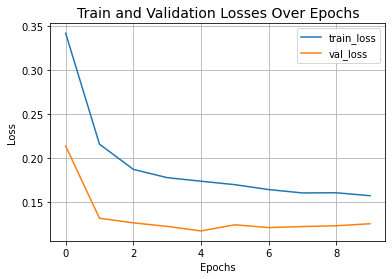

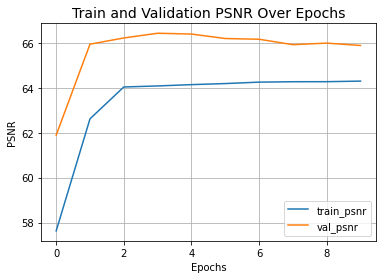

In [ ]:
def charbonnier_loss(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.square(y_true - y_pred) + tf.square(1e-3)))


def peak_signal_noise_ratio(y_true, y_pred):
    return tf.image.psnr(y_pred, y_true, max_val=255.0)


optimizer = keras.optimizers.Adam(learning_rate=1e-4)
simple_model.compile(
    optimizer=optimizer, loss=charbonnier_loss, metrics=[peak_signal_noise_ratio]
)

history = simple_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_peak_signal_noise_ratio",
            factor=0.5,
            patience=5,
            verbose=1,
            min_delta=1e-7,
            mode="max",
        )
    ],
)

plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()


plt.plot(history.history["peak_signal_noise_ratio"], label="train_psnr")
plt.plot(history.history["val_peak_signal_noise_ratio"], label="val_psnr")
plt.xlabel("Epochs")
plt.ylabel("PSNR")
plt.title("Train and Validation PSNR Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()


# ConvNet

## 모델 생성

In [ ]:
def conv_net():
  input_tensor = keras.Input(shape=[None, None, 3])

  #################################################################################
  ##
  ## 새로운 인공지능망 구조 짜기

  x1 = layers.Conv2D(64, kernel_size=(3, 3), padding="same")(input_tensor)
  conv_1 = layers.Conv2D(64, kernel_size=(3, 3), padding="same")(x1)
  conv_2 = layers.Conv2D(256, kernel_size=(2, 2), padding="same")(conv_1)
  conv_3 = layers.Conv2D(512, kernel_size=(3, 3), padding="same")(conv_2)


  conv = layers.Conv2D(3, kernel_size=(3, 3), padding="same")(conv_5)

  ##
  #################################################################################

  output_tensor = layers.Add()([input_tensor, conv])
  return keras.Model(input_tensor, output_tensor)

conv_model = conv_net()

In [ ]:
conv_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_640 (Conv2D)            (None, None, None,   1792        ['input_3[0][0]']                
                                64)                                                               
                                                                                                  
 conv2d_641 (Conv2D)            (None, None, None,   32896       ['conv2d_640[0][0]']             
                                128)                                                        

In [ ]:
save_model("ConvNet_model", conv_model)

## 모델 훈련

Epoch 1/10
75/75 [==============================] - 8s 82ms/step - loss: 0.2361 - peak_signal_noise_ratio: 61.3932 - val_loss: 0.1772 - val_peak_signal_noise_ratio: 63.4366 - lr: 1.0000e-04
Epoch 2/10
75/75 [==============================] - 6s 82ms/step - loss: 0.1887 - peak_signal_noise_ratio: 62.6580 - val_loss: 0.1262 - val_peak_signal_noise_ratio: 65.5620 - lr: 1.0000e-04
Epoch 3/10
75/75 [==============================] - 6s 83ms/step - loss: 0.1704 - peak_signal_noise_ratio: 63.4370 - val_loss: 0.1229 - val_peak_signal_noise_ratio: 65.7449 - lr: 1.0000e-04
Epoch 4/10
75/75 [==============================] - 6s 83ms/step - loss: 0.1739 - peak_signal_noise_ratio: 63.2896 - val_loss: 0.1274 - val_peak_signal_noise_ratio: 65.4110 - lr: 1.0000e-04
Epoch 5/10
75/75 [==============================] - 6s 83ms/step - loss: 0.1608 - peak_signal_noise_ratio: 63.8298 - val_loss: 0.1195 - val_peak_signal_noise_ratio: 65.9980 - lr: 1.0000e-04
Epoch 6/10
75/75 [==============================] 

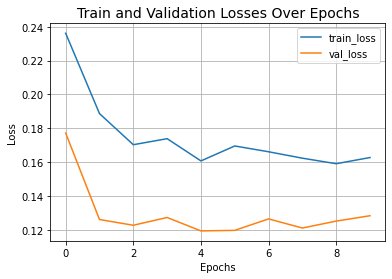

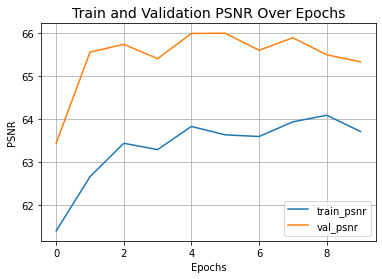

In [ ]:
def charbonnier_loss(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.square(y_true - y_pred) + tf.square(1e-3)))


def peak_signal_noise_ratio(y_true, y_pred):
    return tf.image.psnr(y_pred, y_true, max_val=255.0)


optimizer = keras.optimizers.Adam(learning_rate=1e-4)
conv_model.compile(
    optimizer=optimizer, loss=charbonnier_loss, metrics=[peak_signal_noise_ratio]
)

history = conv_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_peak_signal_noise_ratio",
            factor=0.5,
            patience=5,
            verbose=1,
            min_delta=1e-7,
            mode="max",
        )
    ],
)

plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()


plt.plot(history.history["peak_signal_noise_ratio"], label="train_psnr")
plt.plot(history.history["val_peak_signal_noise_ratio"], label="val_psnr")
plt.xlabel("Epochs")
plt.ylabel("PSNR")
plt.title("Train and Validation PSNR Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()


# Inference

In [ ]:
def plot_results(images, titles, figure_size=(12, 12)):
    fig = plt.figure(figsize=figure_size)
    for i in range(len(images)):
        fig.add_subplot(1, len(images), i + 1).set_title(titles[i])
        _ = plt.imshow(images[i])
        plt.axis("off")
    plt.show()


def infer(original_image):
    image = keras.preprocessing.image.img_to_array(original_image)
    image = image.astype("float32") / 255.0
    image = np.expand_dims(image, axis=0)
    output = model.predict(image)
    output_image = output[0] * 255.0
    output_image = output_image.clip(0, 255)
    output_image = output_image.reshape(
        (np.shape(output_image)[0], np.shape(output_image)[1], 3)
    )
    output_image = Image.fromarray(np.uint8(output_image))
    original_image = Image.fromarray(np.uint8(original_image))
    return output_image


## Infernece on LOL dataset

In [ ]:
def infer(target_model, original_image):
   image = keras.preprocessing.image.img_to_array(original_image)
   image = image.astype("float32") / 255.0
   image = np.expand_dims(image, axis=0)
   output = target_model.predict(image)
   output_image = output[0] * 255.0
   output_image = output_image.clip(0, 255)
   output_image = output_image.reshape(
       (np.shape(output_image)[0], np.shape(output_image)[1], 3)
   )
   output_image = Image.fromarray(np.uint8(output_image))
   original_image = Image.fromarray(np.uint8(original_image))
   return output_image

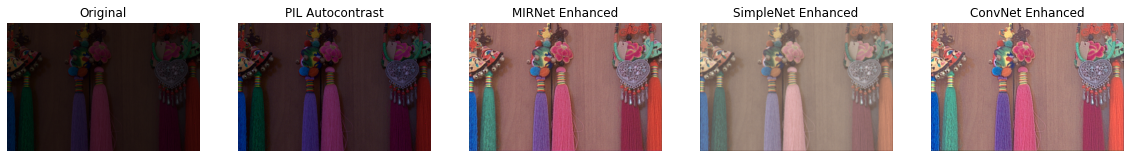

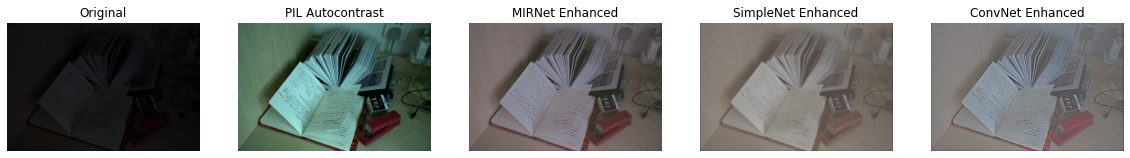

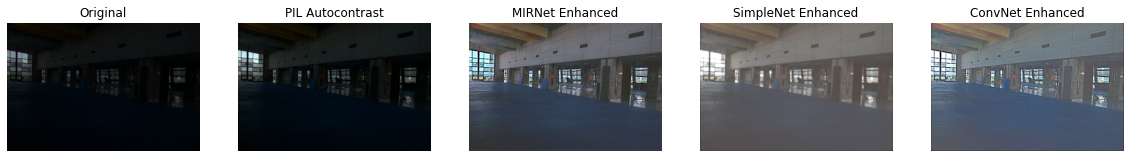

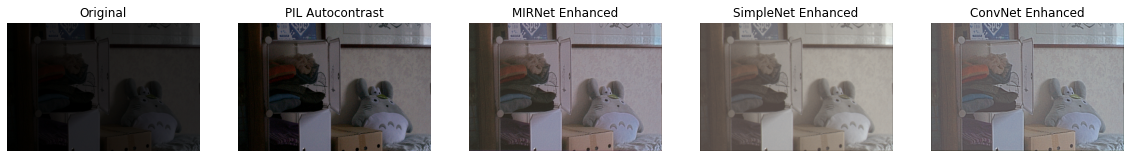

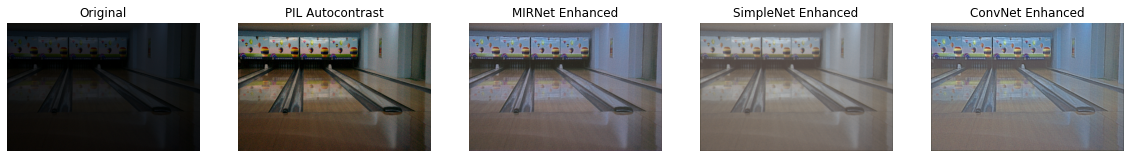

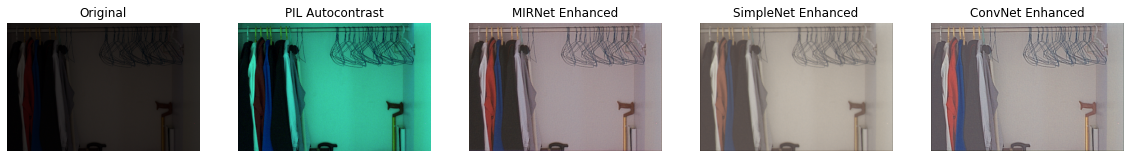

In [ ]:
for low_light_image in random.sample(test_low_light_images, 6):
    original_image = Image.open(low_light_image)
    enhanced_image_MIRNet = infer(model, original_image)
    enhanced_image_simple = infer(simple_model, original_image)
    enhanced_image_ConvNet = infer(conv_model, original_image)
    plot_results(
        [original_image, ImageOps.autocontrast(original_image), enhanced_image_MIRNet, enhanced_image_simple, enhanced_image_ConvNet],
        ["Original", "PIL Autocontrast", "MIRNet Enhanced", "SimpleNet Enhanced", "ConvNet Enhanced"],
        (20, 12),
    )

## Inference on User Input Image

### 파일 업로드

In [1]:
from google.colab import files

In [22]:
# colab 드라이브에 파일 업로드하기
uploaded = files.upload()

for fn in uploaded.keys():
  filename = fn

image_uploaded = Image.open(filename)

Saving test_1.jpg to test_1.jpg


### 이미지 전처리

In [23]:

# 불러온 이미지를 MIRNet이 사용하는 이미지 규격에 맞게 전처리하기
#   resolution 400x600
#   .png

image_resized = image_uploaded.resize((400, 600))
image_resized.save('result.png', 'png')

# 전처리 완료된 이미지를 infer() 에 통과시켜 결과 내기